In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

### Classification

Build a classification model for the default of credit card clients dataset. More info here:
https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

- Explore the data
- Make sure you build a full data pipeline
- Do you require any data pre-processing? Are all the features useful? (Use only raw features)
- set the random seed to 123 (For splitting or any other random algorithm)
- Split data into training (80%) and testing (20%)
- Follow similar procedure as the one for week 2 (End-to-end Machine Learning Project). Remember apendix B
- Study the ROC Curve, decide threshold
- Use 2 classifiers.
    - Random Forest
        - tune only: n_estimators: {4, 5, 10, 20, 50} 
    - KNN Classfier 
        - tune only: n_neighbors: {3, 5, 10, 20} 
    - Which one performs better in the cross validation?
    
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

- Cross-validation with 5-folds

- Other paramenters -> Use default

# Frame the Problem and Look at the Big Picture

The objective is to predict whether or not a credit card client will default for their payment in the next month. We will be using the better of 2 classifiers namely, Random Forest and KNN Classifier, and determine the best of a given set of hyperparameters by using GridSearchCV. 

In a business context, this project would be potentially useful at 2 phases of credit lending:
1. Active credit card client: It can be used to identify clients that are likely to default in the next payment and therefore flag these clients. It may also be possible to extend the model to detect it 2-3 months prior to a potential default so certain actions may be taken.

2. During credit card application: The results/model of the this project can be further used as part of the application process to improve the company's assessment of the creditworthiness of the clients applying for credit cards or other credit products 

One limitation of this study is that the data is from April 2005 to September 2005 and is considered stale for use in the current period or in the near future.

Another major limitation of this study is that the data are from credit card clients in Taiwan and cannot be used in Canada (or any other country for that matter) due to fundamental differences in income levels, culture, consumer behaviour, credit industry landscape, and other conditions.

# Get the Data

Data is obtained through the University of California, Irvine Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients). The data is open for public use and no authorizations are required.

Data is imported from the UCI website:

In [2]:
df = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls", 
                   sheet = 0, skiprows= 1, header = 0)

Show all columns. Not ideal when there's a lot of columns but this dataset has a manageable number of columns.

In [3]:
pd.set_option('display.max_columns', None)

Let's take a look at the headers and a few rows to better understand the data structure

In [4]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [8]:
df.PAY_0.unique()

array([ 2, -1,  0, -2,  1,  3,  4,  8,  7,  5,  6])

In [15]:
df.PAY_2.unique()

array([ 2,  0, -1, -2,  3,  5,  7,  4,  1,  6,  8])

In [16]:
df.PAY_3.unique()

array([-1,  0,  2, -2,  3,  4,  6,  7,  1,  5,  8])

In [17]:
df.PAY_4.unique()

array([-1,  0, -2,  2,  3,  4,  5,  7,  6,  1,  8])

In [18]:
df.PAY_5.unique()

array([-2,  0, -1,  2,  3,  5,  4,  7,  8,  6])

In [19]:
df.PAY_6.unique()

array([-2,  2,  0, -1,  3,  6,  4,  7,  8,  5])

Data description on the website provides information about the features and the values therein.:

* **LIMIT_BAL**: Amount of given credit (in NT dollars) for the invidiual consumer credit and his/her family credit

* **GENDER**:
    * 1 = Male
    * 2 = Female

* **EDUCATION**: 
    * 1 = Graduate school
    * 2 = University
    * 3 = High School
    * 4 = Others 

* **MARITAL STATUS**:
    * 1 = Married
    * 2 = Single
    * 3 = Others

* **AGE**: In years

* **PAY_#**: History of past monthly payment records (April 2005 to September 2005). The scale is  
    * -1 = Duly paid
    * 1 = One month delay
    * 2 = 2 month delay 
    ...
    * N = N month delay
    
* **BILL_AMT#**: Amount on bill statement (in NT dollars) from April 2005 to September 2005

* **PAY_AMT#**: Amount of previous payment (in NT dollars) from April 20015 to September 2005

* **default payment next month**: The data label
    * 0 = Did not default
    * 1 = Default
    
Note that PAY_0 seems to be an odd column header since the BILL_AMT and PAY_AMT columns go from 1 (April 2005) to 6 (September 2005). While this isn't absolutely necessary, we will change it to PAY_1 for consistency and clarity

In [ ]:
df = df.rename(columns = {'PAY_0':'PAY_1'})
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


A quick summary on the description of the data with info() shows that there are no missing values and all of the data is reprsented as integers.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_1                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5                     30000 non-null int64
BILL_AMT6               

Next, split the data into training set and test set. We will set aside 20% of the test data as test set.

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 123)

# Explore the Data

Make a copy of the train_set for exploration then generate some descriptive statistics

In [ ]:
credit = train_set.copy()
credit.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,14964.174292,167893.486667,1.603125,1.851958,1.553375,35.488458,-0.017542,-0.135292,-0.170042,-0.224292,-0.265583,-0.294042,51068.758375,49006.879333,46955.185083,43389.105625,40297.970375,38708.777542,5656.319917,5.910454e+03,5280.658708,4763.854250,4805.837667,5277.577958,0.222167
std,8660.479272,130109.666875,0.489260,0.790560,0.521452,9.217424,1.125331,1.199812,1.201709,1.170630,1.136707,1.152014,73353.609147,71140.365649,68841.868958,64572.844994,60878.153831,59355.284889,16757.718059,2.134743e+04,17973.951980,15162.056345,15251.828322,18222.046645,0.415711
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-15308.000000,-67526.000000,-157264.000000,-65167.000000,-61372.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7467.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3566.500000,2920.000000,2663.000000,2310.000000,1744.250000,1200.000000,990.000000,8.150000e+02,390.000000,281.750000,234.000000,110.750000,0.000000
50%,14975.000000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22250.000000,20940.500000,20038.000000,19032.000000,18019.000000,16812.500000,2100.000000,2.010000e+03,1801.500000,1500.000000,1500.000000,1500.000000,0.000000
75%,22460.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66910.500000,63428.250000,59970.250000,54591.500000,50237.250000,49132.750000,5009.000000,5.000000e+03,4600.000000,4026.000000,4009.250000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,855086.000000,891586.000000,927171.000000,961664.000000,873552.000000,1.227082e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


Although these are numeric, descriptive statistics for the ID, EDUCATION, and MARRIAGE features are not helpful since these are identifiers (for ID) and non-pattern-based numeric representations for categorical variables (e.g. if education was say total number of years of education, or if marriage was say # of people in household then these statistics would make sense).

Some observations:
* Average credit provided to clients is around $167,900

* Max credit issued is 1,000,000, median is 140,000, and IQR is 190,000 suggesting decreasing number of credit issued for higher amounts

* More females than males

* Average age of clients is 35, youngest client is 21, and oldest is 79

* Average bill amounts range from 38,709 to 51,069 per month

* Max payment delay is 8 months

* Some bill amounts are negative 

* Average payment amounts range from 4,764 to 5,910 per month

* Around 22% of the clients defaulted on their payment for the next month

Next, let's do a pairwise plot of the features excluding the PAY_#, BILL_AMT#, and PAY_AMT# features

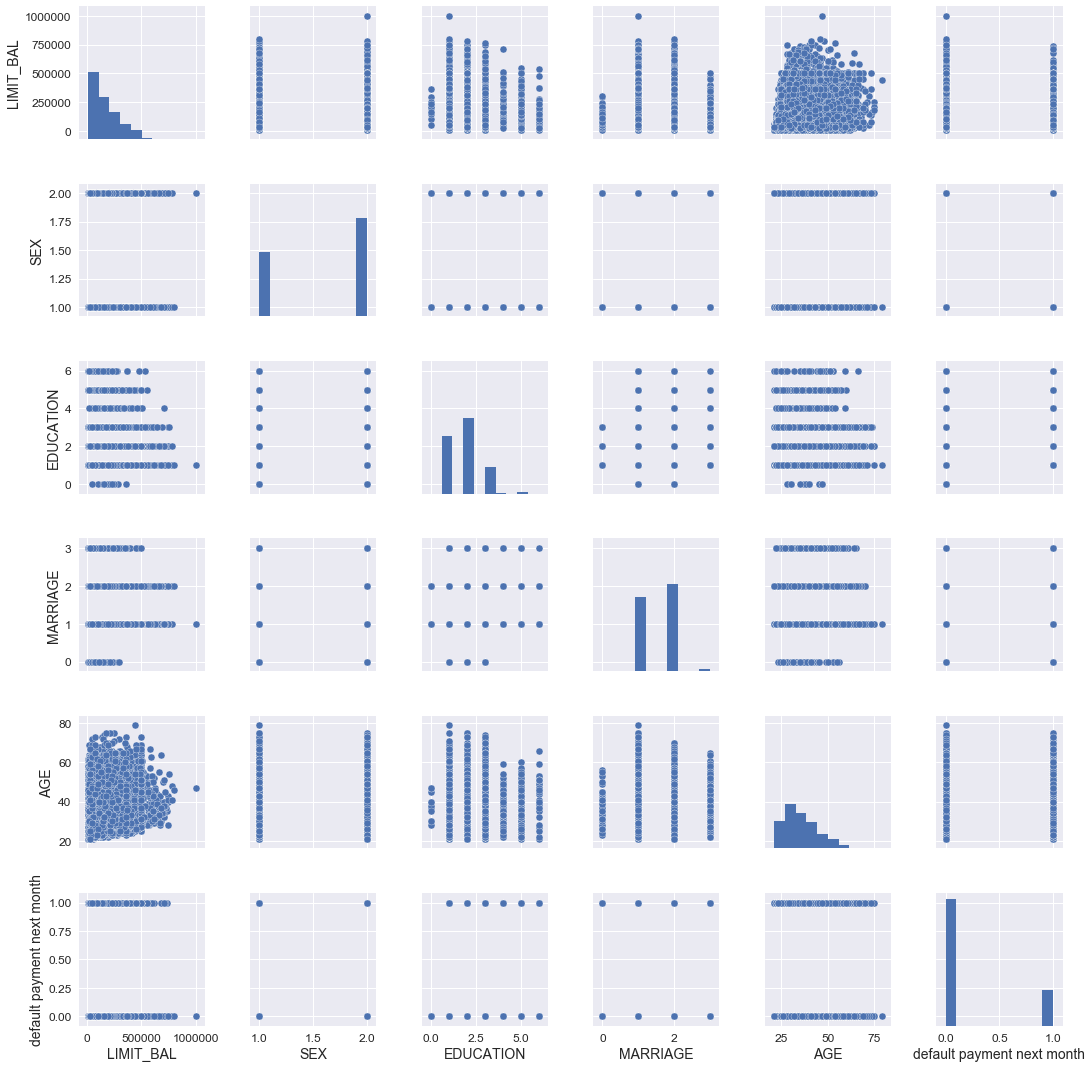

In [ ]:
credit_nobillpay = credit[["LIMIT_BAL", "SEX","EDUCATION","MARRIAGE","AGE", "default payment next month"]].copy()
sns.pairplot(credit_nobillpay)

There seems to be some correlation between the ages and the limit balance provided to the consumer. As for the plots with sex, education, and marriage, these plots do not tell much and would be better plotted using other plot forms.

The target attribute is the "default payment next month". To be sure, let's check that the label is truly 0 or 1

In [ ]:
credit["default payment next month"].value_counts()

0    18668
1     5332
Name: default payment next month, dtype: int64

Let's check the values under EDUCATION. The values range from 0 to 6 however the data description does not provide any context on values other than 1, 2, and 3.

In [ ]:
credit["EDUCATION"].value_counts()

2    11198
1     8494
3     3938
5      229
4       91
6       39
0       11
Name: EDUCATION, dtype: int64

Let's check the values under "MARRIAGE". The value of 0 is not defined in the data description.

In [ ]:
credit["MARRIAGE"].value_counts()

2    12798
1    10905
3      260
0       37
Name: MARRIAGE, dtype: int64

# Prepare the Data

In [ ]:
credit = train_set.drop("default payment next month", axis = 1)

credit_labels = train_set["default payment next month"].copy()

The current encoding for the categorical variables of EDUCATION, and MARRIAGE may be in ordinal numbers but is not ideal since the numbers themselves don't lend meaning (e.g. EDUCATION has values not defined in the data description). We will then use one-hot encoding for both the EDUCATION and MARRIAGE features. 

Let's build the preprocessing pipeline for the numerical and categorical features.

In [ ]:
from CategoricalEncoder import CategoricalEncoder
from DataFrameSelector import DataFrameSelector

In [ ]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["LIMIT_BAL", "AGE", "PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6",
                                              "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
                                              "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"])),
        ])

In [ ]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["SEX", "EDUCATION", "MARRIAGE"])),
        ("cat_encoder", CategoricalEncoder(encoding='onehot-dense')),
    ])

In [ ]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

Preprocesing pipeline is complete and let's prepare the data

In [ ]:
credit_prepared = preprocess_pipeline.fit_transform(credit)

# SHORT-LIST PROMISING MODELS and FINE-TUNE THE SYSTEM

Short listing promising models has been done as per the requirements of the homework. Moreover, a list of hyperparameters are provided to determine the best model. These two steps will be merged since they are intertwined by the nature of the homework.

- Use 2 classifiers.
    - Random Forest
        - tune only: n_estimators: {4, 5, 10, 20, 50} 
    - KNN Classfier 
        - tune only: n_neighbors: {3, 5, 10, 20} 

### Random Forest classifier 

Let's build the Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

RF = RandomForestClassifier(random_state=123)

Create a function to plot the ROC curve

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

Using GridSearchCV, determine the best hyperparameter for the given list of n_estimators {4, 5, 10, 20, 50}.

We wil use CV = 5 and the scoring to be the roc_auc (area under the curve)

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [{'n_estimators':  [4, 5, 10, 20, 50]}]

grid_search_RF = GridSearchCV(RF, param_grid, cv=5 ,scoring='roc_auc')
grid_search_RF.fit(credit_prepared, credit_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=123,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [4, 5, 10, 20, 50]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

The best hyperparameter in the given list for Random Forest is when n_estimators = 50

In [ ]:
grid_search_RF.best_params_

{'n_estimators': 50}

For documentation, let's show the resulting Area Under the Curve for each of the n_estimators used

In [ ]:
cvres_RF = grid_search_RF.cv_results_

for mean_score, params in zip(cvres_RF["mean_test_score"], cvres_RF["params"]):
    print(mean_score, params)

0.689432983715 {'n_estimators': 4}
0.70114402169 {'n_estimators': 5}
0.725070343295 {'n_estimators': 10}
0.74448960009 {'n_estimators': 20}
0.754135222935 {'n_estimators': 50}


Let's plot the ROC curve for the best RF estimator

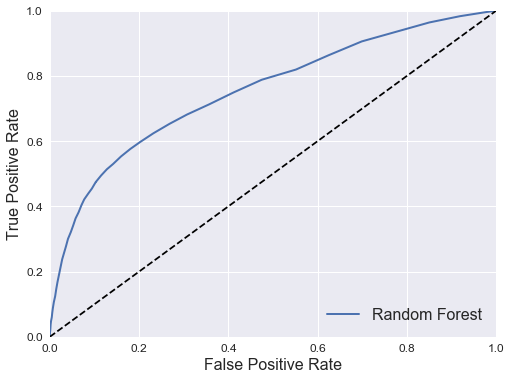

In [ ]:
best_RF_model = grid_search_RF.best_estimator_

y_probas_RF = cross_val_predict(best_RF_model, credit_prepared, credit_labels, cv=5, method="predict_proba")
y_scores_RF = y_probas_RF[:, 1] 
fpr_RF, tpr_RF, thresholds_RF = roc_curve(credit_labels,y_scores_RF)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_RF, tpr_RF, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

### KNN Classifier

First, let's build the KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier()

Using GridSearchCV, determine the best hyperparameter for the given list of n_neighbors {3, 5, 10, 20}.

We wil use CV = 5 and the scoring to be the roc_auc (area under the curve)

In [ ]:
param_grid = [{'n_neighbors':  [3, 5, 10, 20]}]

grid_search_KNN = GridSearchCV(KNN, param_grid, cv=5 ,scoring='roc_auc')
grid_search_KNN.fit(credit_prepared, credit_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [3, 5, 10, 20]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

The best hyperparameter in the list for KNN is when n_neighbors = 20

In [ ]:
grid_search_KNN.best_params_

{'n_neighbors': 20}

For documentation, let's show the resulting Area Under the Curve for each of the n_neighbors used

In [ ]:
cvres_KNN = grid_search_KNN.cv_results_
for mean_score, params in zip(cvres_KNN["mean_test_score"], cvres_KNN["params"]):
    print(mean_score, params)

0.582156524319 {'n_neighbors': 3}
0.600679894629 {'n_neighbors': 5}
0.626676780624 {'n_neighbors': 10}
0.644265674088 {'n_neighbors': 20}


Let's plot the ROC curve for the best KNN estimator

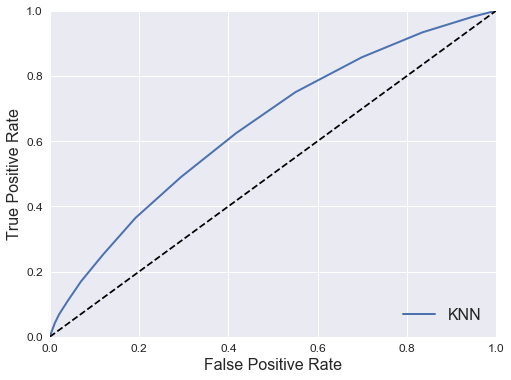

In [ ]:
best_KNN_model = grid_search_KNN.best_estimator_

y_probas_KNN = cross_val_predict(best_KNN_model, credit_prepared, credit_labels, cv=5, method="predict_proba")
y_scores_KNN = y_probas_KNN[:, 1] 
fpr_KNN, tpr_KNN, thresholds_KNN = roc_curve(credit_labels,y_scores_KNN)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_KNN, tpr_KNN, "KNN")
plt.legend(loc="lower right", fontsize=16)
plt.show()

The best RF estimator (with n_estimators = 50) has an ROC AUC of 0.754135222935.

Compare this to the best KNN estimator (with n_neighors = 20) which has an ROC AUC of 0.644265674088.

Effectively, the best model out of the models trained is Random Forest with n_estimators = 50. This is also demonstrated by plotting the curves for the best RF and KNN estimators. 

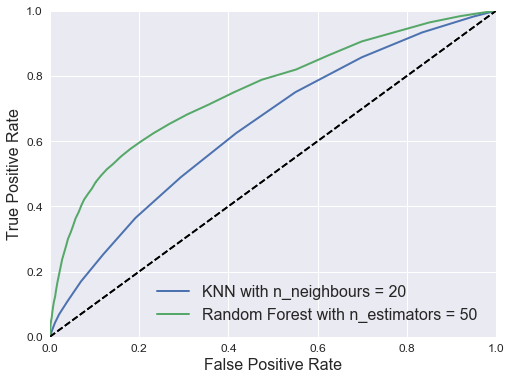

In [ ]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_KNN, tpr_KNN, "KNN with n_neighbours = 20")
plot_roc_curve(fpr_RF, tpr_RF, "Random Forest with n_estimators = 50 ")
plt.legend(loc="lower right", fontsize=16)
plt.show()

### Final Model Performance

Given that we found our best estimator, let's measure its performance on the test set.

Preprocess the data:

In [ ]:
credit_test = test_set.drop("default payment next month", axis = 1)

credit_test_labels = test_set["default payment next month"].copy()

credit_test_prepared = preprocess_pipeline.fit_transform(credit_test)

Plot the ROC curve

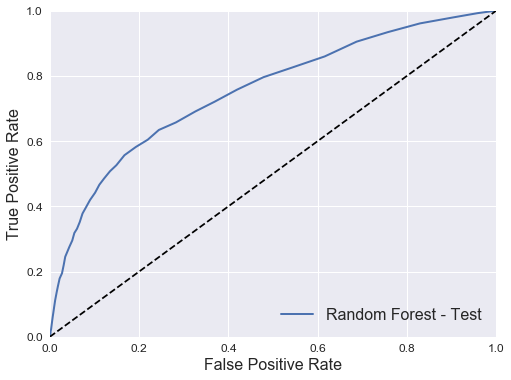

In [ ]:
y_probas_RF_test = cross_val_predict(best_RF_model, credit_test_prepared, credit_test_labels, cv=5, method="predict_proba")
y_scores_RF_test = y_probas_RF_test[:, 1] 
fpr_RF_test, tpr_RF_test, thresholds_RF_test = roc_curve(credit_test_labels,y_scores_RF_test)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_RF_test, tpr_RF_test, "Random Forest - Test")
plt.legend(loc="lower right", fontsize=16)
plt.show()

Compute the AUC score

In [ ]:
roc_auc_score(credit_test_labels, y_scores_RF_test)

0.75158657087091485

#### Conclusions

**Response:**

The best classifier found is Random Forest with n_estimators = 50. Both the training set and test set had an ROC AUC score of about 0.75 with the test set performing slightly worse. 

While the problem is limited to raw features only, I would want to include one additional feature that I think would be relevant to the task. That is the % of the bill amount that was paid for the month.

With respect to features, not all raw features are necessary. potentially the last 2-3 months of information on payment status is necessary. However, I can think of 2 additional measures that can perhaps improve the classifiers:

1. % of the bill amount that was paid for the month (so payments > or = to 100% means consumer is either on time on payments or paying down debt)
2. Taking measure #1 a bit further is to get the the change in % of outstanding bill paid (e.g. say 75% of bill paid in month 1 then 45% of bill paid in month 2 shows a worsening payment rate and also reflects a ballooning bill). This means that an decreasing rate of change in % of outstanding bill paid means they can't keep up with payments.

I think these 2 measure would be more useful than the current raw features for BILL_AMT# and PAY_AMT#.